In [1]:
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import boxcox , probplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PowerTransformer,QuantileTransformer

import pandas as pd
import numpy as np

In [2]:
dt = load_boston()
x = dt.data
y = dt.target

cols = dt.feature_names

df = pd.DataFrame(data=x ,columns=cols[:])
df['PRICE'] = y
print(len(cols))

13


In [3]:
def plt_dist(var):
    fig,ax = plt.subplots(ncols = 4 ,figsize =(14,8))
    probplot(var,plot = ax[0])
    sns.boxplot(var,ax=ax[1],orient='v')
    sns.distplot(var,ax=ax[2])
    sns.regplot(x=var,y=df['PRICE'],ax=ax[3])
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    ax[3].grid(True)
    plt.show()

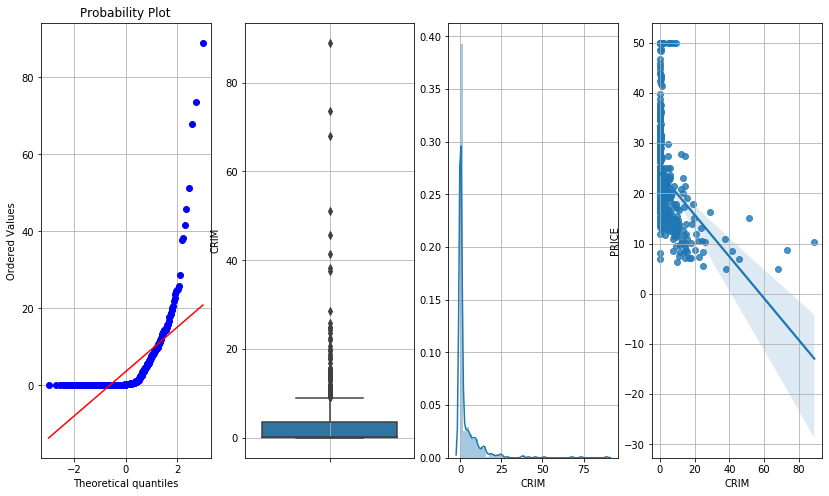

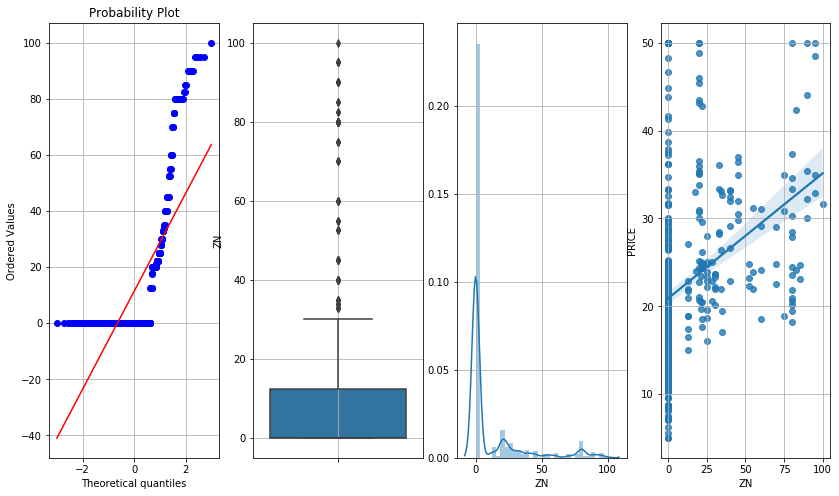

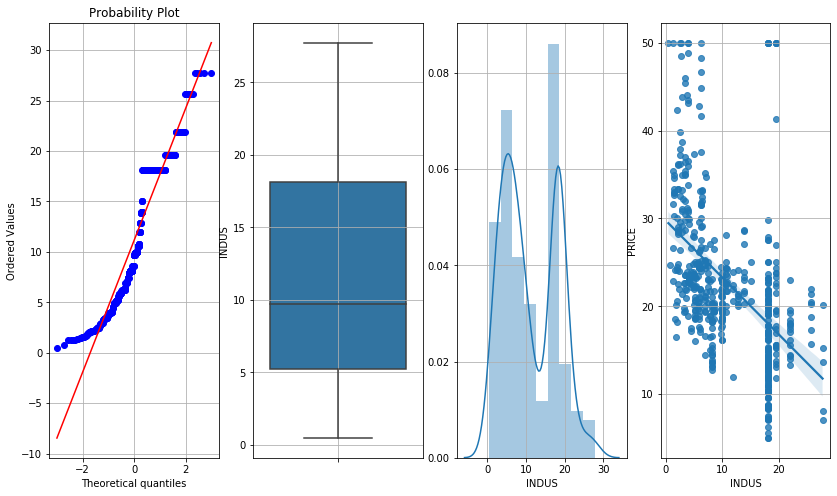

C:\Users\admin\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


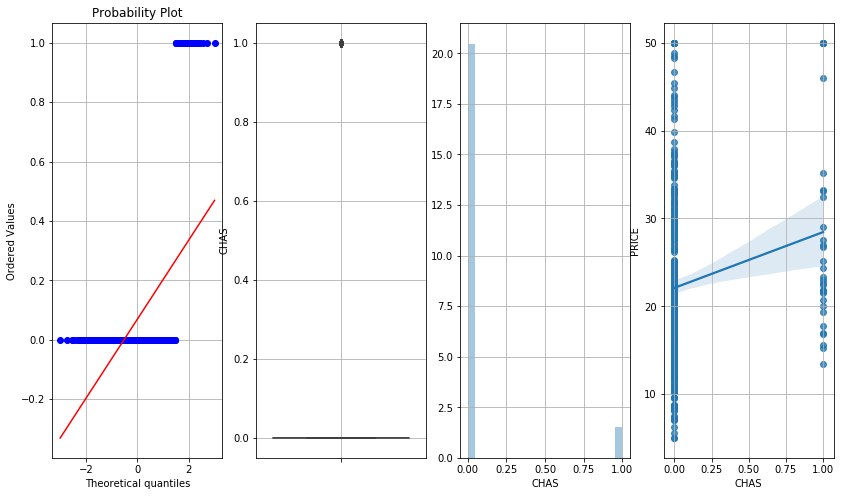

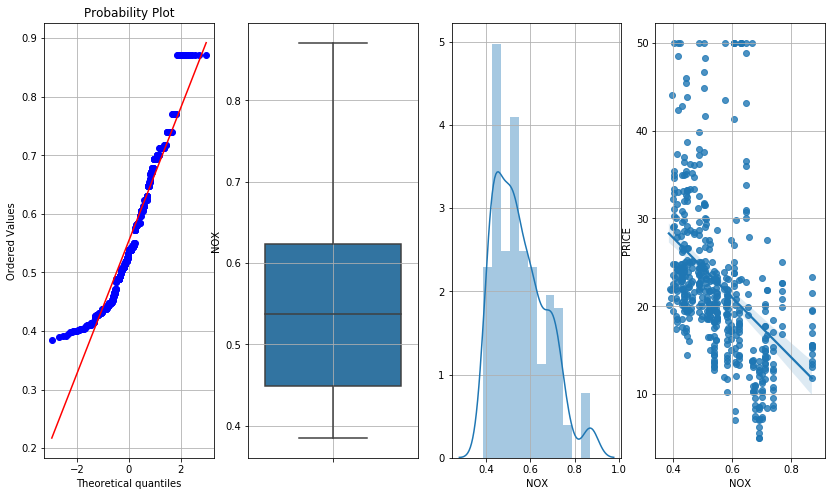

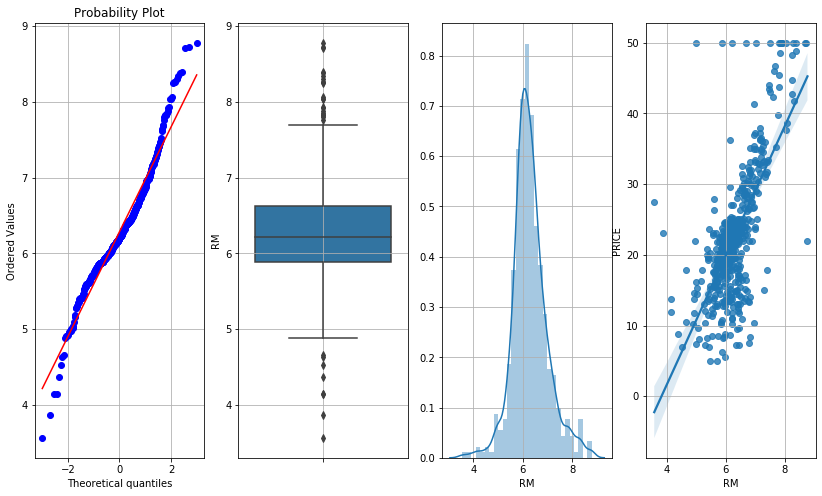

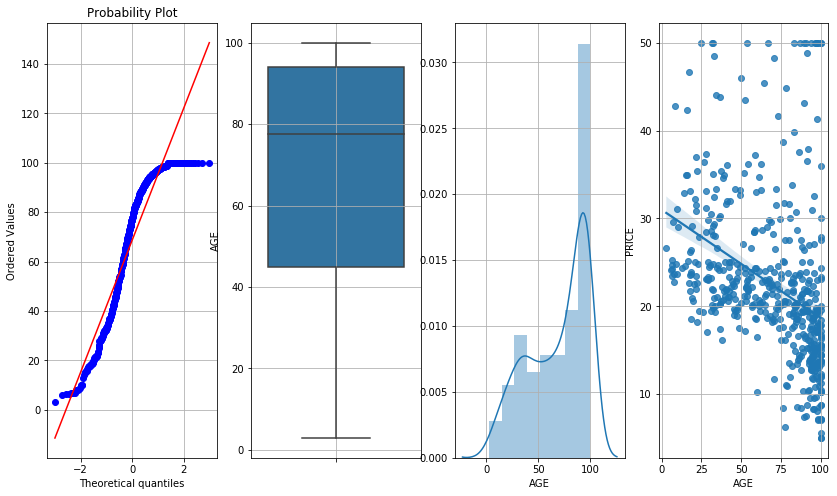

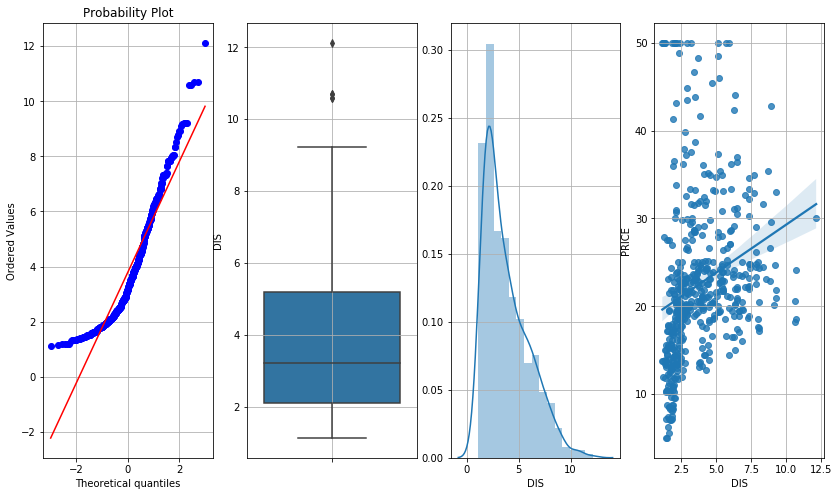

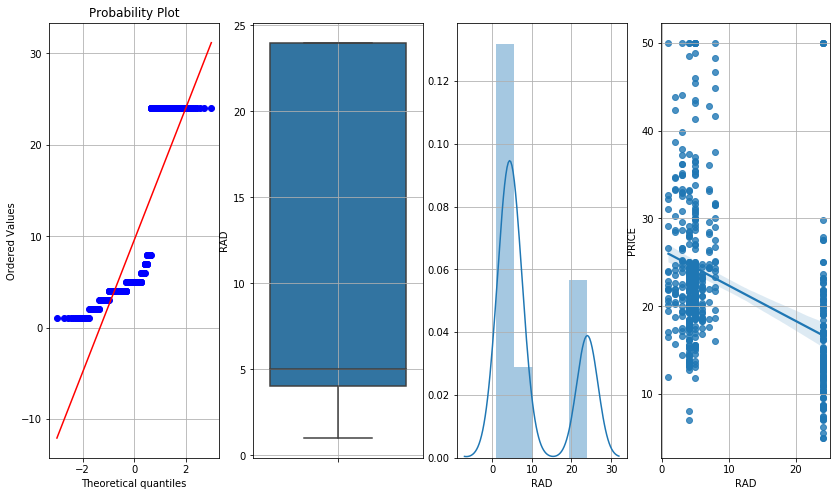

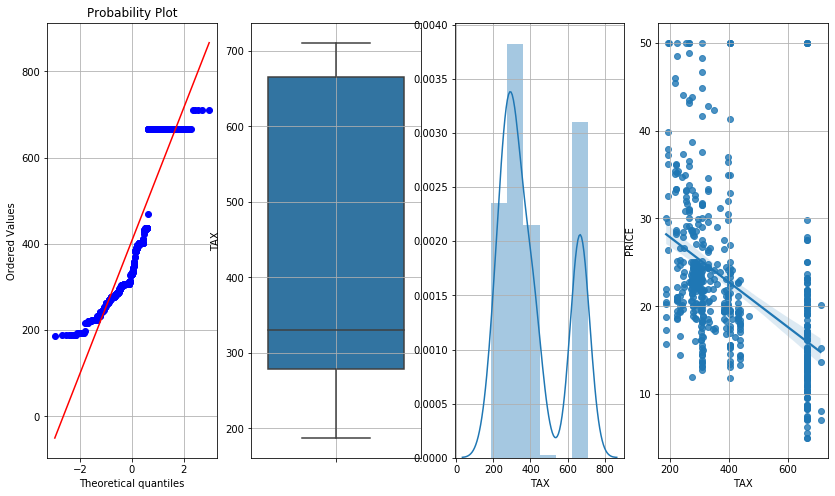

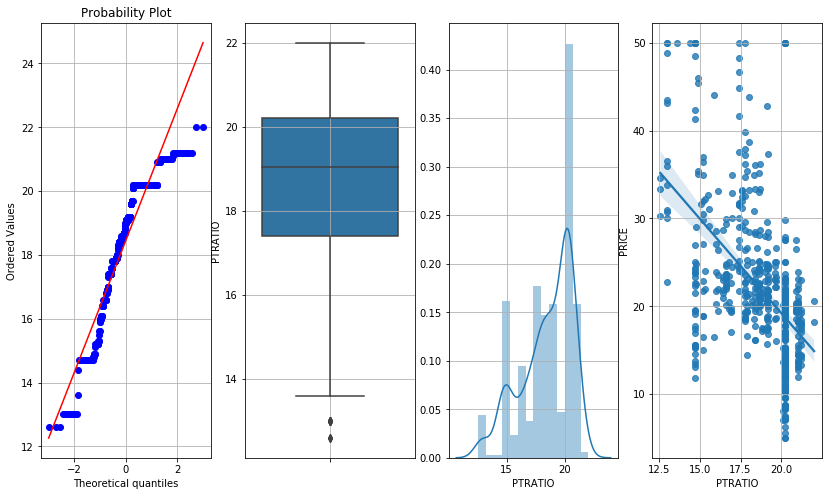

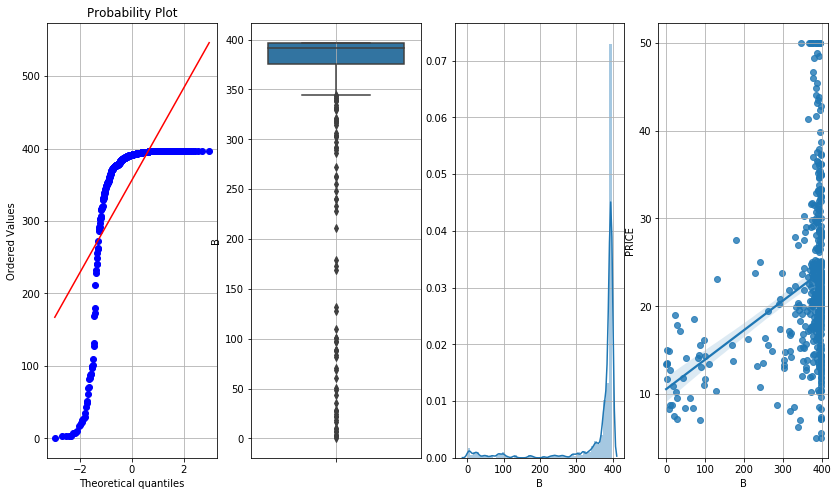

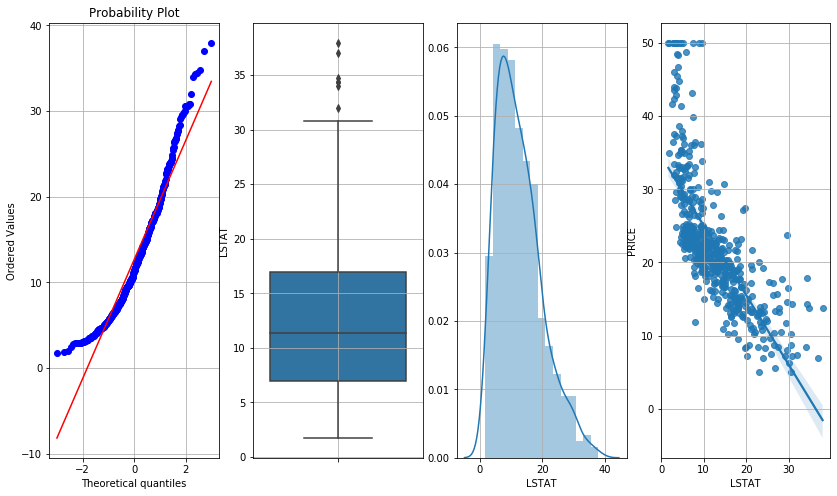

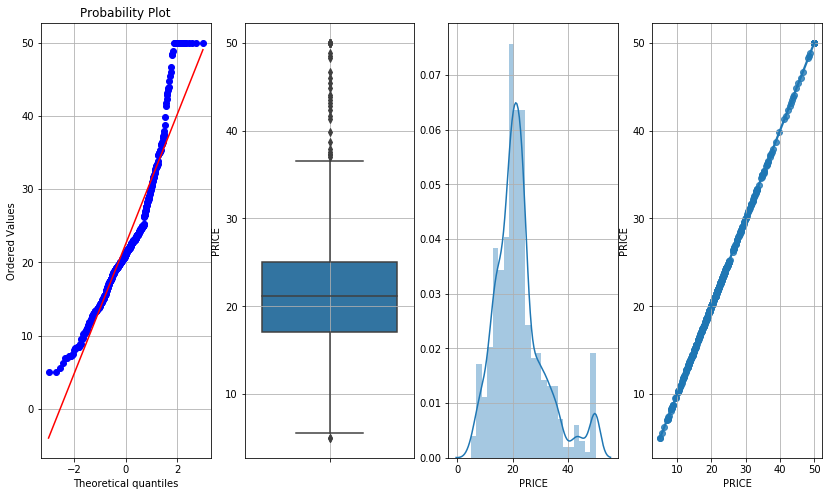

In [4]:
for i in df.columns:
    plt_dist(df[i])

In [5]:
pt = PowerTransformer()
y_bx  =pt.fit_transform(y.reshape(-1,1))

In [6]:
x_m = PowerTransformer().fit_transform(df.iloc[:,:-1])
df2 = pd.DataFrame(data=x_m, columns=df.columns[:-1])
df2[df.columns[-1]] = y_bx
df2['CRIM'] = np.log1p(df['CRIM'])
#df2['B']  = np.log1p(df['B'])
#df2['AGE']  = np.log1p(df['AGE'])
#df2['LSTAT'] = np.log1p(df['LSTAT'])


x_train,x_test1,y_train,y_test1 = train_test_split(df2.iloc[:,:-1],df2.iloc[:,-1],test_size=0.15,random_state=42)

df_train = pd.DataFrame(x_train)
df_train['PRICE'] = y_train

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     202.9
Date:                Mon, 18 May 2020   Prob (F-statistic):          1.25e-165
Time:                        22:49:57   Log-Likelihood:                -203.01
No. Observations:                 430   AIC:                             432.0
Df Residuals:                     417   BIC:                             484.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1702      0.042      4.098      0.0

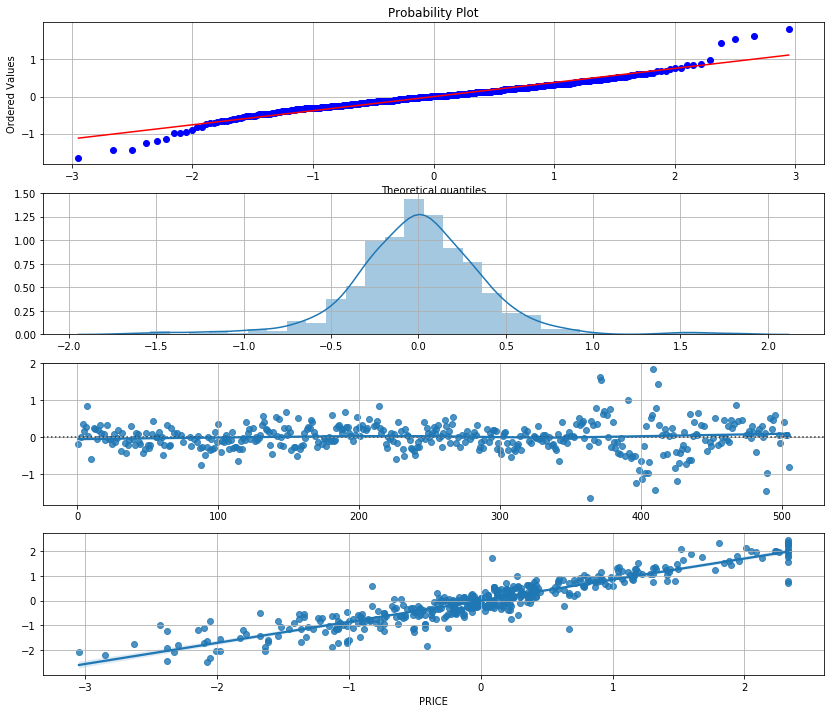

In [7]:
#crim + zn +chas + nox + rm + age + dis + indus + tax+ b + lstat + ptratio + RAD
md = smf.ols('PRICE ~  CRIM+RM + DIS +RAD+TAX+PTRATIO +LSTAT+NOX  '
           '  + CRIM:RM + CRIM:LSTAT +INDUS:RAD + RM:LSTAT ',data=df_train).fit()
print(md.summary())
t = [variance_inflation_factor(df2.values,i)  for i in range(0,13)]
for i in range(0,13):
    print(df_train.columns[i] , " ", t[i])
    
y_pred = md.predict(x_test1)
y_t = pt.inverse_transform(y_test1.values.reshape(-1,1))
y_p = pt.inverse_transform(y_pred.values.reshape(-1,1))
print(r2_score(y_t,y_p))


print(mean_squared_error(y_t,y_p) ** 0.5)

fig,ax = plt.subplots(nrows=4,figsize=(14,12))
plt.rc('grid' ,)
probplot(md.resid,plot=ax[0])
ax[0].grid()
sns.distplot(md.resid,ax=ax[1])
ax[1].grid()
sns.residplot(y = md.resid,x=df_train.index,ax=ax[2],lowess=True)
ax[2].grid(True)
sns.regplot(x=df_train.iloc[:,-1],y=md.predict(df_train.iloc[:,:-1]),ax=ax[3])
ax[3].grid(True)
plt.show()

In [8]:
# P_Value < 0.05 not normally distributes
from statsmodels.stats.diagnostic import kstest_normal,normal_ad
print('P-Value ',normal_ad(md.resid)[1])

P-Value  9.179744370119195e-10


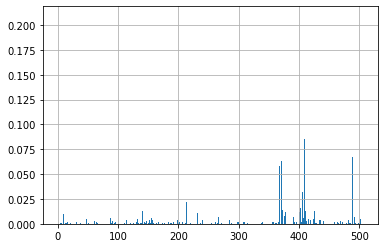

In [9]:
from statsmodels.stats.outliers_influence import OLSInfluence
p = OLSInfluence(md)
dis , _ = p.cooks_distance

plt.bar(x= dis.index ,height=dis)
plt.grid(True)
plt.show()

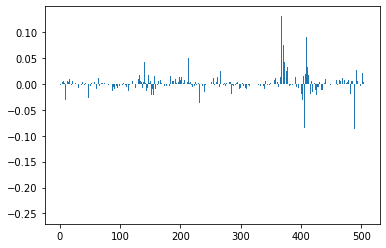

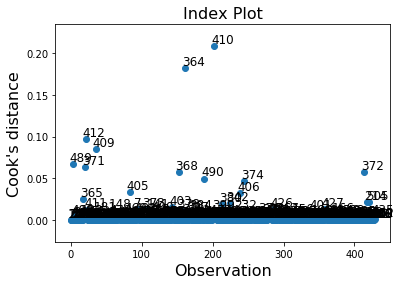

In [10]:
plt.bar(x= dis.index ,height=p.influence)
p.plot_index();

In [11]:
# deleting outlier instances
df_out =  df_train[dis < 4/df_train.shape[0]]

In [12]:
md = smf.ols('PRICE ~   DIS +RAD+TAX+PTRATIO  '
           '  + CRIM:RM + CRIM:LSTAT +INDUS:RAD + RM:LSTAT +NOX +LSTAT +RM',data=df_out).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     368.0
Date:                Mon, 18 May 2020   Prob (F-statistic):          2.94e-197
Time:                        22:50:04   Log-Likelihood:                -59.837
No. Observations:                 399   AIC:                             143.7
Df Residuals:                     387   BIC:                             191.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0863      0.020      4.218      0.0

In [13]:
t = [variance_inflation_factor(df_out.values,i)  for i in range(0,14)]
for i in range(0,14):
    print(df_out.columns[i] , " ", t[i])

CRIM   1.8130012262418207
ZN   2.077197461748648
INDUS   3.77819912193169
CHAS   1.1053672361118019
NOX   7.116118733991908
RM   2.5449034729812543
AGE   3.7869985058258053
DIS   6.165424971727356
RAD   2.907758812203377
TAX   3.3741268299715115
PTRATIO   1.804587586051424
B   1.458589571240014
LSTAT   5.63461635784671
PRICE   5.980216215936535


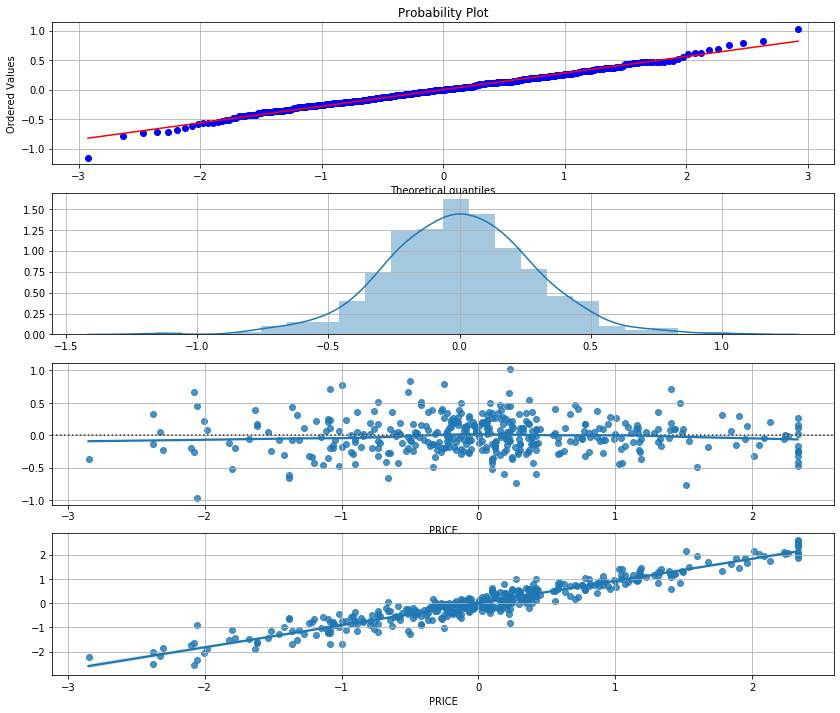

In [14]:
fig,ax = plt.subplots(nrows=4,figsize=(14,12))
plt.rc('grid' ,)
probplot(md.resid,plot=ax[0])
ax[0].grid()
sns.distplot(md.resid,ax=ax[1])
ax[1].grid()
sns.residplot(y = md.resid,x=df_out.iloc[:,-1],ax=ax[2],lowess=True)
ax[2].grid(True)
sns.regplot(x=df_out.iloc[:,-1],y=md.predict(df_out.iloc[:,:-1]),ax=ax[3])
ax[3].grid(True)
plt.show()

In [15]:
#normality test on residuals > 0.05 then normaly distributed
from statsmodels.stats.diagnostic import normal_ad
print('P-Value ',normal_ad(md.resid)[1])

P-Value  0.18384183334017626


In [16]:
#Prediction on test size

y_pred = md.predict(x_test1)
y_t = pt.inverse_transform(y_test1.values.reshape(-1,1))
y_p = pt.inverse_transform(y_pred.values.reshape(-1,1))
print('R2_SCORE ',r2_score(y_t,y_p))

print('RMSE ',mean_squared_error(y_t,y_p) ** 0.5)

R2_SCORE  0.9292212467308416
RMSE  2.149912131957991


In [17]:
df3 = pd.DataFrame()
df3['NOX'] = df_out['NOX']
df3['RM'] = df_out['RM']
df3['DIS'] = df_out['DIS']
df3['RAD'] = df_out['RAD']
df3['TAX'] = df_out['TAX']
df3['PTRATIO'] = df_out['PTRATIO']
df3['LSTAT'] = df_out['LSTAT']

df3['CRIM:RM'] = df_out['CRIM'] * df_out['RM']
df3['CRIM:LSTAT'] = df_out['CRIM'] * df_out['LSTAT']
df3['INDUS:RAD'] = df_out['INDUS'] * df_out['RAD']
df3['RM:LSTAT'] = df_out['RM'] *df_out['LSTAT']
df3['PRICE'] =df_out['PRICE']

In [18]:
t = [variance_inflation_factor(df3.values,i)  for i in range(0,12)]
for i in range(0,12):
    print(df3.columns[i] , " ", t[i])

NOX   6.367592441026976
RM   7.268508943420553
DIS   5.5848436975368525
RAD   3.3578818339769203
TAX   3.859522163952412
PTRATIO   1.568655387278019
LSTAT   5.777876577600774
CRIM:RM   4.532382303979453
CRIM:LSTAT   8.127064807893177
INDUS:RAD   2.100940248613025
RM:LSTAT   2.5185767492293425
PRICE   11.009248365620497


In [19]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [20]:
reg =LinearRegression()
kf = KFold(n_splits=7,shuffle=True,random_state=92)
l = []
for train,test in kf.split(df3.iloc[:,:-1],df3.iloc[:,-1]):
    x_train,y_train = df3.iloc[train,:-1],df3.iloc[train ,-1]
    x_test,y_test = df3.iloc[test,:-1],df3.iloc[test ,-1]
    reg.fit(x_train,y_train)
    print(r2_score(y_test,reg.predict(x_test)))
    l.append(r2_score(y_test,reg.predict(x_test)))
l = np.array(l)
l.mean() , l.std()

0.8917410197410904
0.8834700851803939
0.864405529822186
0.9004929767262063
0.9385564217922684
0.8980151725336794
0.9426504935365569


(0.9027616713331973, 0.026362506310208252)

1. RESIDUAL ARE NORMALY DISTRIBUTED 
2. NO MULTICOLLINEARITY OR LITTLE MULTICOLLINEARITY
3. LINEAR RELATIONSHIP
4. HOMOGENEOUS DISTRIBUTION OF ERROR TERMS 
5. OUTLIERS ARE REMOVED
6. NO AUTOCORRELATION

In [21]:
import statsmodels.stats.api as sms

In [22]:
# no heteroscedasticity
sms.het_goldfeldquandt(md.resid , md.model.exog)[1]

0.5472406507484311

In [23]:
#no heteroscedasticity
sms.spec_white(md.resid,md.model.exog)[1]

0.3401706573781574

In [24]:
#no autocorrelation
sms.durbin_watson(md.resid)

2.0507380495107665

In [25]:
#Linearity
sms.linear_lm(md.resid,md.model.exog)[1]

0.0678034526575877